In [1]:
import os
import csv
import re
import glob
import math
import psycopg2
import numpy as np
import pandas as pd
#from sql_queries import *
from IPython.core.display import HTML
from IPython.display import display
from datetime import datetime as dt
from datetime import timedelta as td
from dateutil import parser
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_columns',999)

In [7]:
with open(r'./flights.txt', 'r') as f:
    d_reader = csv.DictReader(f)
    #get fieldnames from DictReader object and store in list
    headers = d_reader.fieldnames
headers


['TRANSACTIONID|FLIGHTDATE|AIRLINECODE|AIRLINENAME|TAILNUM|FLIGHTNUM|ORIGINAIRPORTCODE|ORIGAIRPORTNAME|ORIGINCITYNAME|ORIGINSTATE|ORIGINSTATENAME|DESTAIRPORTCODE|DESTAIRPORTNAME|DESTCITYNAME|DESTSTATE|DESTSTATENAME|CRSDEPTIME|DEPTIME|DEPDELAY|TAXIOUT|WHEELSOFF|WHEELSON|TAXIIN|CRSARRTIME|ARRTIME|ARRDELAY|CRSELAPSEDTIME|ACTUALELAPSEDTIME|CANCELLED|DIVERTED|DISTANCE']

In [8]:
df = pd.read_csv(r'./flights.txt',sep='|',names=headers[0].split('|'),encoding='utf-8',skiprows=1)

In [9]:
df.shape

(1191805, 31)

In [56]:
def to_t_delt(number):
    if pd.isnull(number):
        return None        
    else:
        return pd.to_timedelta(math.floor(number/100)*60+(number/100-math.floor(number/100))*100,'m')
        

In [57]:
def to_t_delt2(number):
    if pd.isnull(number):
        return pd.to_timedelta(0,'m')        
    else:
        return pd.to_timedelta(number,'m')

In [58]:
df['FLIGHTDATE_']=pd.to_datetime(df['FLIGHTDATE'].astype(str),format='%Y%m%d')

df['CRSDEPTIME_']=df['CRSDEPTIME'].apply(lambda x: to_t_delt(x))
df['FLIGHTDATETIME_']=df['FLIGHTDATE_']+df['CRSDEPTIME_']

In [59]:
df['DEPTIME_']=df['DEPTIME'].apply(lambda x: to_t_delt(x))

In [104]:
df['CRSARRTIME_']=df['CRSARRTIME'].apply(lambda x: to_t_delt(x))

In [60]:
df['DEPDELAY_']=df['DEPDELAY'].apply(lambda x: to_t_delt2(x))

In [61]:
df['ARRDELAY_']=df['ARRDELAY'].apply(lambda x: to_t_delt2(x))

In [62]:
df['CRSELAPSEDTIME_']=df['CRSELAPSEDTIME'].apply(lambda x: to_t_delt2(x))

In [63]:
df['ACTUALELAPSEDTIME_']=df['ACTUALELAPSEDTIME'].apply(lambda x: to_t_delt2(x))

In [64]:
df['ARRTIME_']=df['ARRTIME'].apply(lambda x: to_t_delt(x))

In [65]:
df['NEXTDAYARR_']=(df['ARRTIME_']-df['DEPTIME_']).astype('timedelta64[m]')

In [66]:
df['DEPDELAYGT15_']=(df['DEPTIME_']-df['CRSDEPTIME_']).astype('timedelta64[m]')

In [159]:
df1=df[df['NEXTDAYARR_']<0]

In [146]:
df.drop(['1990'],axis=1,inplace=True)
df['1990']=df.apply(lambda _:'1990-01-01 00:00:00',axis=1)

In [147]:
df['1990_d']=pd.to_datetime(df['1990'])

In [154]:
df['ARRTIME_D']=df['1990_d']+df['ARRTIME_']

In [157]:
df['CRSDEPTIME_D']=df['1990_d']+df['CRSDEPTIME_']

In [158]:
df['CRSARRTIME_D']=df['1990_d']+df['CRSARRTIME_']

In [ ]:
df['DEPTIME_D']=df['1990_d']+df['DEPTIME_']

In [161]:
df1[['FLIGHTDATETIME_','DEPTIME_D','ACTUALELAPSEDTIME','ARRTIME_D','NEXTDAYARR_','DEPDELAYGT15_','CRSARRTIME_D']].head(5)

,FLIGHTDATETIME_,DEPTIME_D,ACTUALELAPSEDTIME,ARRTIME_D,NEXTDAYARR_,DEPDELAYGT15_,CRSARRTIME_D
90,2002-09-15 20:20:00,1990-01-01 21:39:00,91.0,1990-01-01 00:10:00,-1289.0,79.0,1990-01-01 22:50:00
126,2001-05-12 18:05:00,1990-01-01 18:05:00,58.0,1990-01-01 18:03:00,-2.0,0.0,1990-01-01 18:10:00
272,2001-01-12 22:45:00,1990-01-01 23:05:00,63.0,1990-01-01 00:08:00,-1377.0,20.0,1990-01-01 23:38:00
576,1992-05-07 14:35:00,1990-01-01 14:49:00,58.0,1990-01-01 14:47:00,-2.0,14.0,1990-01-01 14:45:00
694,2000-09-22 12:55:00,1990-01-01 13:01:00,59.0,1990-01-01 13:00:00,-1.0,6.0,1990-01-01 13:05:00


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191805 entries, 0 to 1191804
Data columns (total 53 columns):
TRANSACTIONID         1191805 non-null int64
FLIGHTDATE            1191805 non-null int64
AIRLINECODE           1191805 non-null object
AIRLINENAME           1191805 non-null object
TAILNUM               1034988 non-null object
FLIGHTNUM             1191805 non-null int64
ORIGINAIRPORTCODE     1191805 non-null object
ORIGAIRPORTNAME       1191805 non-null object
ORIGINCITYNAME        1191805 non-null object
ORIGINSTATE           1180963 non-null object
ORIGINSTATENAME       1180963 non-null object
DESTAIRPORTCODE       1191805 non-null object
DESTAIRPORTNAME       1191805 non-null object
DESTCITYNAME          1191805 non-null object
DESTSTATE             1180967 non-null object
DESTSTATENAME         1180967 non-null object
CRSDEPTIME            1191805 non-null int64
DEPTIME               1163470 non-null float64
DEPDELAY              1163470 non-null float64
TAXIOUT        

In [69]:
ts=df.groupby(['ORIGAIRPORTNAME','ORIGINAIRPORTCODE'])['ORIGINAIRPORTCODE'].count().rename('count')
#ts

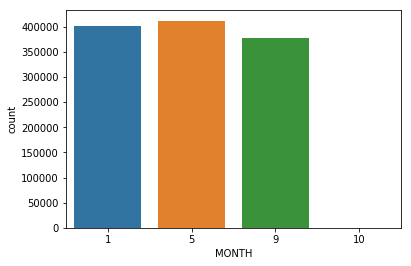

In [69]:
df['MONTH']=df['FLIGHTDATETIME_'].dt.month
ts=df.groupby(['MONTH'])['FLIGHTDATETIME_'].count().rename('count').reset_index()
sns.barplot(x='MONTH',y='count',data=ts)

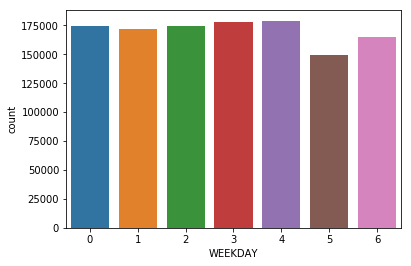

In [70]:
df['WEEKDAY']=df['FLIGHTDATETIME_'].dt.weekday
ts=df.groupby(['WEEKDAY'])['FLIGHTDATETIME_'].count().rename('count').reset_index()
sns.barplot(x='WEEKDAY',y='count',data=ts)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

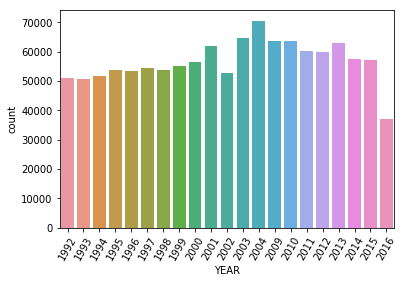

In [71]:
df['YEAR']=df['FLIGHTDATETIME_'].dt.year
ts=df.groupby(['YEAR'])['FLIGHTDATETIME_'].count().rename('count').reset_index()
sns.barplot(x='YEAR',y='count',data=ts)
plt.xticks(rotation=60)

In [72]:
#check primary key
duplicateID=df[df['TRANSACTIONID'].duplicated()]
duplicateID

,TRANSACTIONID,FLIGHTDATE,AIRLINECODE,AIRLINENAME,TAILNUM,FLIGHTNUM,ORIGINAIRPORTCODE,ORIGAIRPORTNAME,ORIGINCITYNAME,ORIGINSTATE,ORIGINSTATENAME,DESTAIRPORTCODE,DESTAIRPORTNAME,DESTCITYNAME,DESTSTATE,DESTSTATENAME,CRSDEPTIME,DEPTIME,DEPDELAY,TAXIOUT,WHEELSOFF,WHEELSON,TAXIIN,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,ACTUALELAPSEDTIME,CANCELLED,DIVERTED,DISTANCE,FLIGHTDATE_,CRSDEPTIME_,FLIGHTDATETIME_,DEPTIME_,DEPDELAY_,ARRDELAY_,CRSELAPSEDTIME_,ACTUALELAPSEDTIME_,ARRTIME_,NEXTDAYARR_,DEPDELAYGT15_,MONTH,WEEKDAY,YEAR


In [243]:
df.ARRTIME_=df.ARRTIME_.map(lambda x: x if x != 'NaT' else None)

In [245]:
df.DEPTIME_=df.DEPTIME_.map(lambda x: x if x != 'NaT' else None)

In [246]:
#df.WHEELSOFF_=df.WHEELSOFF_.map(lambda x: x if x != 'NaT' else None)

In [247]:
#df.WHEELSON_=df.WHEELSON_.map(lambda x: x if x != 'NaT' else None)

In [73]:
#check missing value
missing=pd.isnull(df).any()
missing

TRANSACTIONID         False
FLIGHTDATE            False
AIRLINECODE           False
AIRLINENAME           False
TAILNUM                True
FLIGHTNUM             False
ORIGINAIRPORTCODE     False
ORIGAIRPORTNAME       False
ORIGINCITYNAME        False
ORIGINSTATE            True
ORIGINSTATENAME        True
DESTAIRPORTCODE       False
DESTAIRPORTNAME       False
DESTCITYNAME          False
DESTSTATE              True
DESTSTATENAME          True
CRSDEPTIME            False
DEPTIME                True
DEPDELAY               True
TAXIOUT                True
WHEELSOFF              True
WHEELSON               True
TAXIIN                 True
CRSARRTIME            False
ARRTIME                True
ARRDELAY               True
CRSELAPSEDTIME         True
ACTUALELAPSEDTIME      True
CANCELLED             False
DIVERTED              False
DISTANCE              False
FLIGHTDATE_           False
CRSDEPTIME_           False
FLIGHTDATETIME_       False
DEPTIME_               True
DEPDELAY_           

In [74]:
def get_mile(distance):
    try:
        miles = re.search('(\d+)',distance, re.IGNORECASE)
        if miles:
            return int(miles.group(1))
        else: return 0
    except ValueError:
        return None

In [75]:
df['DISTANCE_']=df['DISTANCE'].apply(get_mile)

In [79]:
def get_airport(name):
    try:
        airport = re.search(':(.*)',name, re.IGNORECASE)
        if airport:
            return airport.group(1)
        else: return 'INVALID VALUE' 
    except ValueError:
        return None

In [10]:
def clean_tail(name):
    try:
        tailnum = re.search('[\s|\w|\d|@]',name, re.IGNORECASE)
        if tailnum:
            blank = re.search('\S',name, re.IGNORECASE)
            if blank:
                return name
            else: return 'UNKNOW'
        else: return 'INVALID VALUE' 
    except ValueError:
        return 'UNKNOW'

In [11]:
df['TAILNUM_']=df['TAILNUM'].astype(str).apply(clean_tail)

In [28]:
textt='United Air Lines Inc.'
line=re.search('(.*)|Inc\.|Co\.]',textt)
print(line)

<_sre.SRE_Match object; span=(0, 21), match='United Air Lines Inc.'>


In [24]:
def get_airline_(name):
    try:
        airline = re.search('(.*)|Inc\.|Co\.]',name)
        if airline:
            return airline.group(1)
        else: return 'INVALID VALUE' 
    except ValueError:
        return None

In [14]:
def get_airline(name):
    try:
        airline = re.search('(.*):',name, re.IGNORECASE)
        if airline:
            return airline.group(1)
        else: return 'INVALID VALUE' 
    except ValueError:
        return None

In [81]:
df['DESTAIRPORTNAME_']=df['DESTAIRPORTNAME'].apply(get_airport)

In [82]:
df['ORIGAIRPORTNAME_']=df['ORIGAIRPORTNAME'].apply(get_airport)

In [25]:
df['AIRLINENAME_2']=df['AIRLINENAME_'].apply(get_airline_)

In [142]:
df.loc[:,['DISTANCE_','AIRLINENAME_','ORIGAIRPORTNAME_','DESTAIRPORTNAME_']].head(5)

,DISTANCE_,AIRLINENAME_,ORIGAIRPORTNAME_,DESTAIRPORTNAME_
0,580,Southwest Airlines Co.,Albuquerque International Sunport,Dallas Love Field
1,744,Continental Air Lines Inc.,Albuquerque International Sunport,George Bush Intercontinental/Houston
2,718,Southwest Airlines Co.,Albuquerque International Sunport,Kansas City International
3,487,Southwest Airlines Co.,Albuquerque International Sunport,McCarran International
4,744,Continental Air Lines Inc.,Albuquerque International Sunport,George Bush Intercontinental/Houston


In [3]:
import pickle

In [95]:
df.shape

(1191805, 50)

In [250]:
df_sm = df.sample(n=10000,random_state=828)

In [265]:
pd.to_pickle(df, "./dummy_b.pkl")

In [101]:
cancel=df.groupby(['CANCELLED'])['CANCELLED'].count().rename('count').reset_index()
cancel


,CANCELLED,count
0,0,347545
1,1,8160
2,F,178357
3,False,637289
4,T,4084
5,True,16370


In [102]:
DIVERTED=df.groupby(['DIVERTED'])['DIVERTED'].count().rename('count').reset_index()
DIVERTED

,DIVERTED,count
0,0,354906
1,1,799
2,F,426572
3,False,407681
4,T,966
5,True,881


In [3]:
%load_ext dotenv
%dotenv

In [261]:
def create_stg_tb(cursor):
    cursor.execute("""
        drop table if exists STG_FACT_FLIGHTS;
        create table if not exists STG_FACT_FLIGHTS (
            ID int not null, TRANSACTIONID int not null, \
            FLIGHTDATE date, AIRLINECODE char(2), TAILNUM text, FLIGHTNUM int, \
            ORIGINAIRPORTCODE char(3), DESTAIRPORTCODE char(3), CRSDEPTIME timestamp, DEPTIME timestamp , DEPDELAY float, \
             CRSARRTIME timestamp, ARRTIME timestamp, ARRDELAY float, \
            CRSELAPSEDTIME float, ACTUALELAPSEDTIME float, CANCELLED varchar(5),  DIVERTED varchar(5), DISTANCE int,\
            DEPDELAYGT15  float, NEXTDAYARR float, FLIGHTDATETIME timestamp,\
            primary key (ID) 
        );
    """)

In [24]:
conn = psycopg2.connect('host={} dbname={} user={} password={}'.format(os.environ.get('HOST')\
                                                                    ,os.environ.get('DATABASE')\
                                                                   ,os.environ.get('USER')\
                                                                    ,os.environ.get('PASSWORD')))
conn.autocommit =True

In [263]:
with conn.cursor() as cursor:
    create_stg_tb(cursor)

In [23]:
conn.close()

In [257]:
stg_flights_data.head()

,TRANSACTIONID,FLIGHTDATE,AIRLINECODE,TAILNUM,FLIGHTNUM,ORIGINAIRPORTCODE,DESTAIRPORTCODE,CRSDEPTIME,DEPTIME,DEPDELAY,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,ACTUALELAPSEDTIME,CANCELLED,DIVERTED,DISTANCE,DEPDELAYGT15,NEXTDAYARR,FLIGHTDATETIME
0,54548800,2002-01-01,WN,N103@@,1425,ABQ,DAL,1990-01-01 14:25:00,1990-01-01 14:25:00,0.0,1990-01-01 16:55:00,1990-01-01 16:52:00,-3.0,90.0,87.0,F,False,580,0.0,147.0,2002-01-01 14:25:00
1,55872300,2002-01-01,CO,N83872,150,ABQ,IAH,1990-01-01 11:30:00,1990-01-01 11:36:00,6.0,1990-01-01 14:26:00,1990-01-01 14:35:00,9.0,116.0,119.0,False,F,744,6.0,179.0,2002-01-01 11:30:00
2,54388800,2002-01-01,WN,N334@@,249,ABQ,MCI,1990-01-01 12:15:00,1990-01-01 13:38:00,83.0,1990-01-01 15:00:00,1990-01-01 16:20:00,80.0,105.0,102.0,F,False,718,83.0,162.0,2002-01-01 12:15:00
3,54486500,2002-01-01,WN,N699@@,902,ABQ,LAS,1990-01-01 19:25:00,1990-01-01 19:25:00,0.0,1990-01-01 19:50:00,1990-01-01 19:48:00,-2.0,85.0,83.0,0,0,487,0.0,23.0,2002-01-01 19:25:00
4,55878700,2002-01-03,CO,N58606,234,ABQ,IAH,1990-01-01 14:55:00,1990-01-01 14:53:00,-2.0,1990-01-01 17:50:00,1990-01-01 17:47:00,-3.0,115.0,114.0,F,False,744,-2.0,174.0,2002-01-03 14:55:00


In [243]:
stg_flights_data.columns=['TRANSACTIONID',
 'FLIGHTDATE',
 'AIRLINECODE',
 'TAILNUM',
 'FLIGHTNUM',
 'ORIGINAIRPORTCODE',
 'DESTAIRPORTCODE',
 'CRSDEPTIME',
 'DEPTIME',
 'DEPDELAY',
 'CRSARRTIME',
 'ARRTIME',
 'ARRDELAY',
 'CRSELAPSEDTIME',
 'ACTUALELAPSEDTIME',
 'CANCELLED',
 'DIVERTED',
 'DISTANCE',
 'DEPDELAYGT15',
 'NEXTDAYARR',
 'FLIGHTDATETIME']

In [254]:
stg_flights_data.to_csv("stg_flights_data_b.csv",index_label='ID')